In [56]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../'))

from evaluation.evaluation_harness import OnlineEvaluator, include_coldstart, include_no_interactions, include_some_interactions, include_all, score_time_spent, score_constant
from statistical_test import estimate_probability_each_model_is_best
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.join(os.path.abspath(''), '../backend'))
from backend.blueprints.recommendation import model_wrappers

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
evaluator = OnlineEvaluator(include_all, score_constant)

In [58]:
current_models = []
for model_wrapper in model_wrappers:
    model_wrapper.model = model_wrapper.definition()
    model_wrapper.model.load(model_wrapper.model_save_file_name, load_published_model=True)
    current_models.append((model_wrapper.model.name(), model_wrapper.model_save_file_name))
evaluation_names = {'evaluation_test_random_model': 'random_model', 'evaluation_test_popularity_model': 'popularity_model', 'evaluation_test_common_neighbors_constant_scoring': 'common_neighbors_constant_scoring', 'evaluation_test_common_neighbors': 'common_neighbors_gaussian_scoring', 'evaluation_test_common_neighbors_percentile_scoring': 'common_neighbors_percentile_scoring', 'evaluation_test_cf_low_weight_decay_increased_lr': 'collborative_filter', 'evaluation_test_gcf_low_weight_decay_increased_lr': 'non_linear_collaborative_filter', 'evaluation_test_mlp_low_weight_decay_increased_lr': 'multilayer_perceptron', 'evaluation_test_ncf_low_weight_decay_increased_lr': 'neural_collaborative_filter', 'evaluation_test_cf_embed_all_except_tags_genres': 'collborative_filter_with_game_embeddings', 'evaluation_test_gcf_embed_all_except_tags_genres': 'non_linear_collaborative_filter_with_game_embeddings', 'evaluation_test_mlp_embed_all_except_tags_genres': 'multilayer_perceptron_with_game_embeddings', 'evaluation_test_ncf_embed_all_except_tags_genres': 'neural_collaborative_filter_with_game_embeddings'}

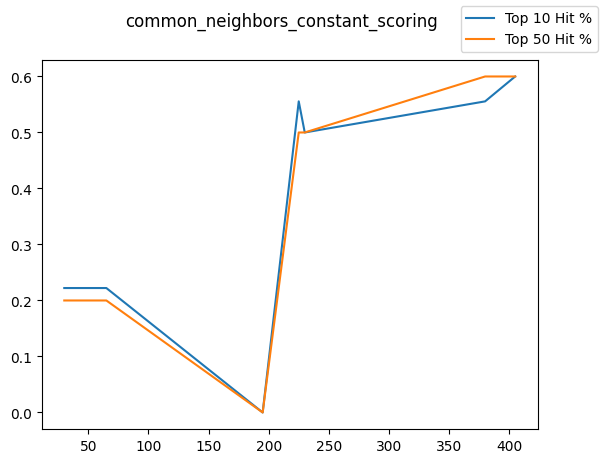

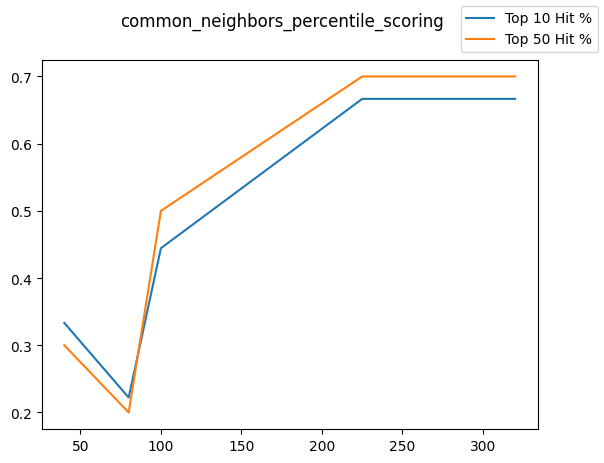

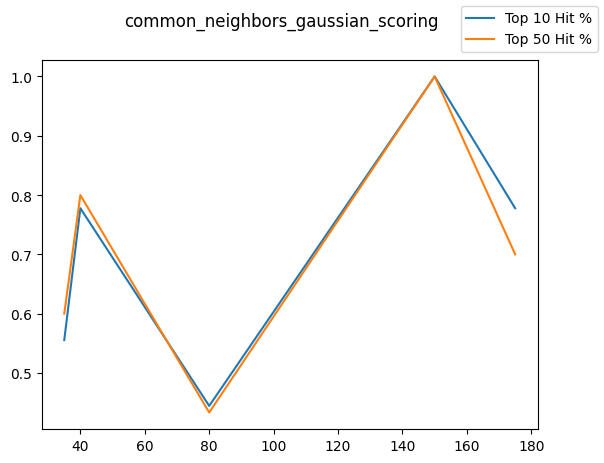

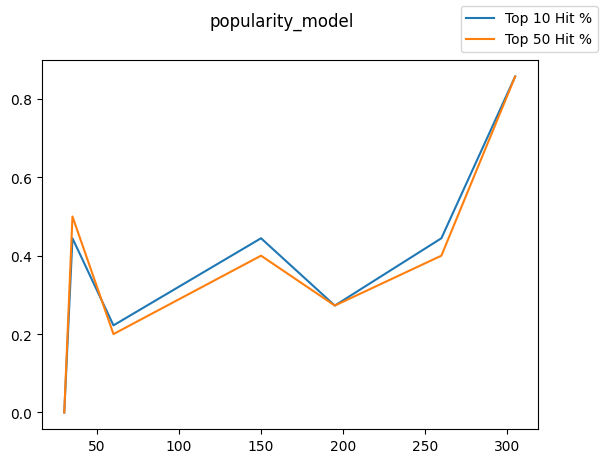

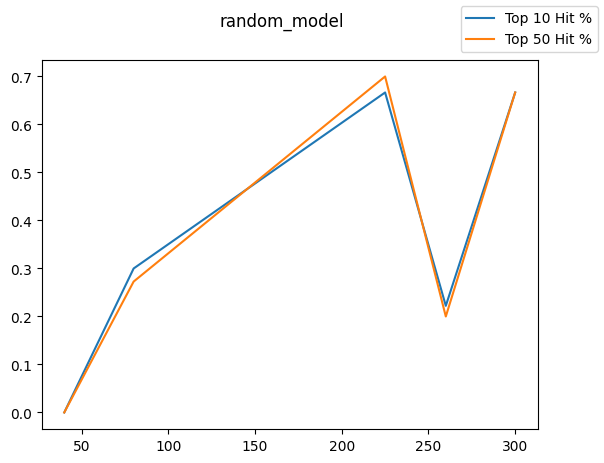

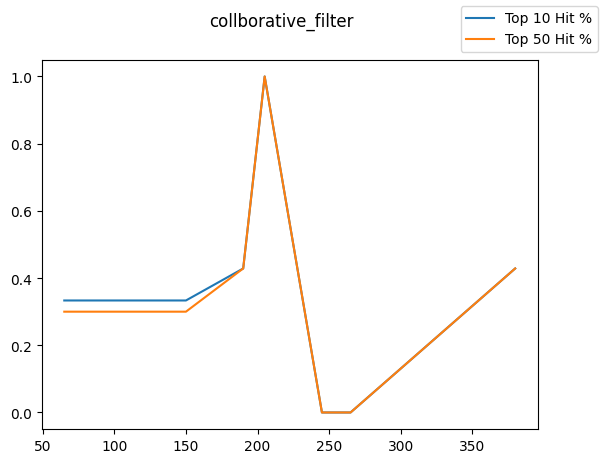

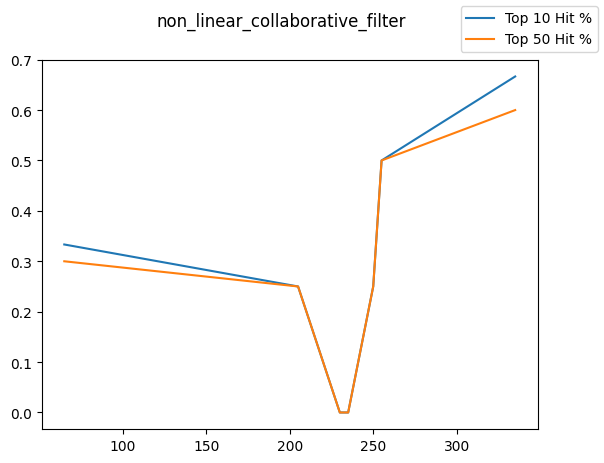

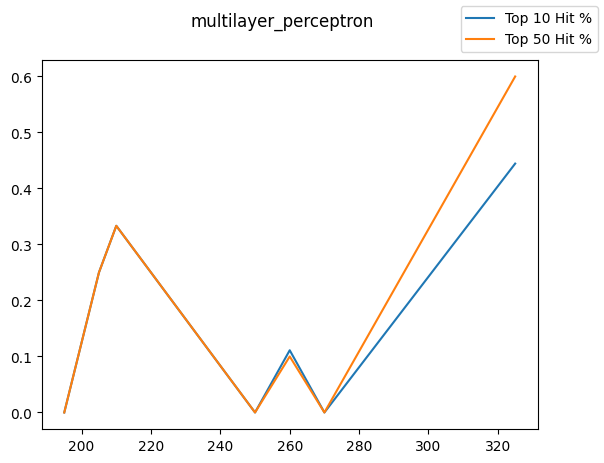

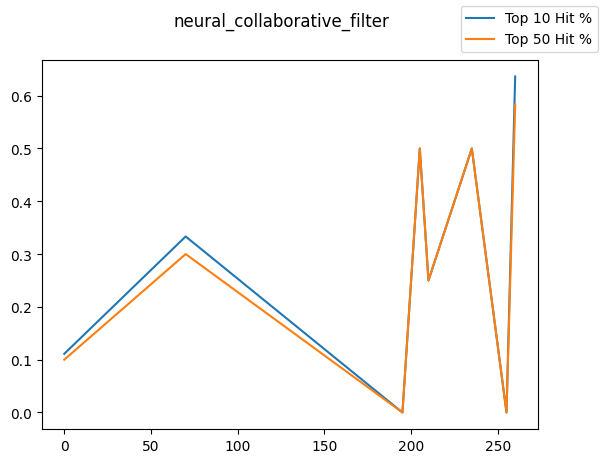

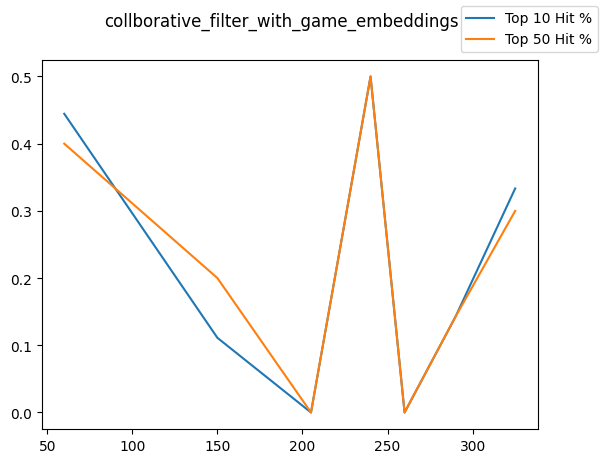

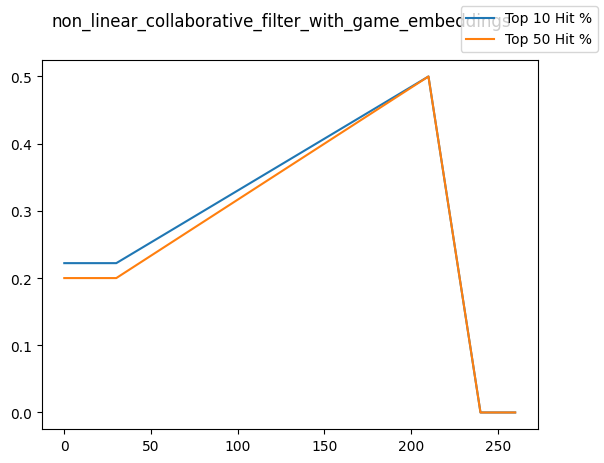

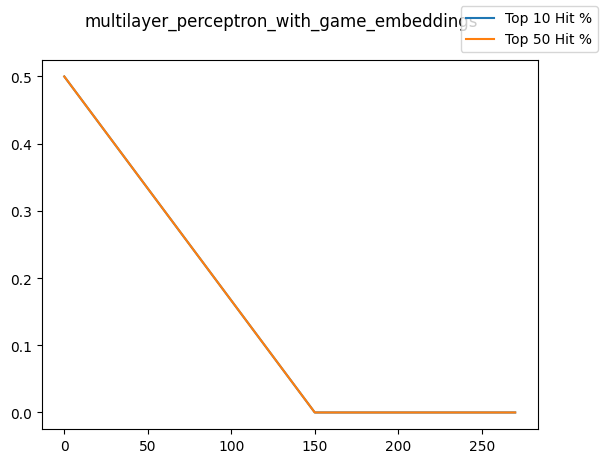

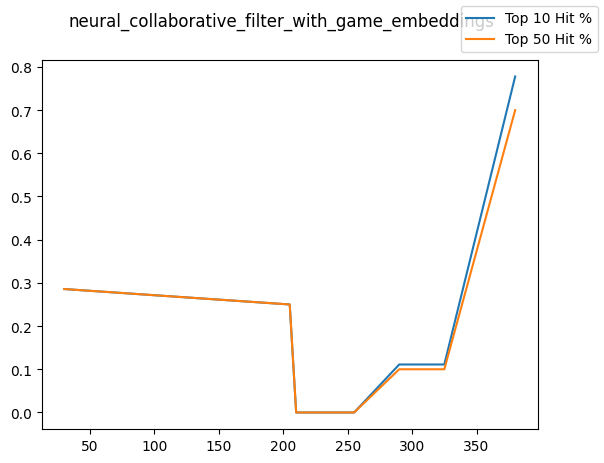

In [59]:
bucket_width = 5

num_interactions = evaluator.all_results["num_game_interactions_external"] + evaluator.all_results["num_game_interactions_local"]
min_num = num_interactions.min()
max_num = num_interactions.max()
for model_name, model_save_path in current_models:
    if model_save_path not in evaluation_names:
        continue
    xs = []
    y_10s = []
    y_50s = []
    for start in range(min_num, max_num, bucket_width):
        evaluator.reset(model_name, model_save_path, start, start + bucket_width)
        if evaluator.metrics["num_interactions"] == 0:
            continue
        evaluator.compute_top_N_hit_percentage(10)
        evaluator.compute_top_N_hit_percentage(50)
        xs.append(start)
        y_10s.append(evaluator.metrics["top_10_hit_percentage"])
        y_50s.append(evaluator.metrics["top_50_hit_percentage"])
    fig = plt.figure()
    fig.suptitle(evaluation_names[model_save_path])
    ax = fig.add_subplot()
    ax.plot(xs, y_10s, label="Top 10 Hit %")
    ax.plot(xs, y_50s, label="Top 50 Hit %")
    fig.legend()

In [60]:
# groups = evaluator.all_results.groupby(by=["rec_model_name", "rec_model_save_path"])
# for (model_name, model_save_path), data in groups:
all_metrics = []
for model_name, model_save_path in current_models:
    evaluator.reset(model_name, model_save_path)
    # evaluator.plot_top_N_hit_percentage_percentiles(10)
    evaluator.compute_top_N_hit_percentage(10)
    # evaluator.plot_top_N_hit_percentage_percentiles(50)
    evaluator.compute_top_N_hit_percentage(50)
    # evaluator.plot_user_rank_roc_curve()
    evaluator.compute_user_rank_auc_roc()
    # evaluator.save_metrics('test_online_evaluator', overwrite=True)
    # pprint(evaluator.metrics)
    all_metrics.append({'model_name': model_name, 'model_save_path': model_save_path, **evaluator.metrics})
    # print()
results = pd.DataFrame(all_metrics)
estimate_probability_each_model_is_best(results, 'user_rank_auc_roc')
estimate_probability_each_model_is_best(results, 'top_10_hit_percentage')
estimate_probability_each_model_is_best(results, 'top_50_hit_percentage')

In [61]:
df = results.loc[results['model_save_path'].isin(evaluation_names), ['model_save_path', 'top_50_hit_percentage_best_probability', 'top_50_hit_percentage', 'top_50_hit_percentage_variance', 'num_interactions', 'top_10_hit_percentage_best_probability', 'top_10_hit_percentage', 'top_10_hit_percentage_variance', 'user_rank_auc_roc_best_probability', 'user_rank_auc_roc', 'user_rank_auc_roc_variance']].copy()
df['model_save_path'] = df['model_save_path'].map(evaluation_names)
display(df.sort_values(by='top_50_hit_percentage_best_probability', ascending=False))

,model_save_path,top_50_hit_percentage_best_probability,top_50_hit_percentage,top_50_hit_percentage_variance,num_interactions,top_10_hit_percentage_best_probability,top_10_hit_percentage,top_10_hit_percentage_variance,user_rank_auc_roc_best_probability,user_rank_auc_roc,user_rank_auc_roc_variance
2,common_neighbors_gaussian_scoring,0.41828,0.573770,0.015677,61,0.40235,0.592593,0.019943,0.00000,0.555495,0.005668
1,common_neighbors_percentile_scoring,0.23224,0.480000,0.033265,50,0.10919,0.407407,0.037037,0.00000,0.368590,0.006364
0,common_neighbors_constant_scoring,0.11442,0.387755,0.036791,49,0.07275,0.350000,0.040643,0.00000,0.452632,0.008695
8,neural_collaborative_filter,0.08253,0.318182,0.048565,44,0.14149,0.388889,0.060317,0.00000,0.538095,0.007332
4,random_model,0.06586,0.325581,0.038160,43,0.11592,0.321429,0.078042,0.00000,0.486453,0.009075
6,non_linear_collaborative_filter,0.05000,0.315789,0.032717,38,0.11497,0.370370,0.054131,0.00261,0.625000,0.011782
7,multilayer_perceptron,0.02300,0.333333,0.017021,48,0.00000,0.111111,0.000000,0.00000,0.227539,0.005650
3,popularity_model,0.00686,0.350649,0.006392,77,0.00775,0.222222,0.025397,0.00000,0.317778,0.004900
11,multilayer_perceptron_with_game_embeddings,0.00453,0.086957,0.037549,23,0.02071,0.153846,0.057692,0.95878,0.952381,0.001942
9,collborative_filter_with_game_embeddings,0.00127,0.244444,0.010253,45,0.01320,0.296296,0.019943,0.00000,0.521390,0.008854
